# Weekly Seasonality Analysis Report
This report analyzes the seasonality of weekly productivity across different departments. By comparing actual productivity to a baseline, we calculate a seasonality index, filter out outliers, and visualize the data for each department individually.

## Step 1: Set Up and Load Data
We start by loading our data from an Excel file. The data consists of two sheets:
- `Actual_2024`: Daily productivity data per department.
- `Base_2024`: Baseline productivity per department.

Let's load the data and examine its structure.


### Inserting data and checking dtypes



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file and each sheet
file_path = 'seasonal.xlsx'
actuals_df = pd.read_excel(file_path, sheet_name='Actual_2024')
baseline_df = pd.read_excel(file_path, sheet_name='Base_2024')

`# Display the first few rows of each dataset to understand their structure`
display(actuals_df.head())
display(baseline_df.head())


,Date,Inbound unloading + palletizing,Unloading GOH,Putaway GOH,Unloading Consumables,% check on inbound,Troubleshooter Inbound,Inbound waiting hours,Masterdata new SKU,OPT putaway + picking,...,Others,Hours Training,Hours customer service direct,Hours Process control,Hours Cleaning,Paid Services ASR/PROJECTS,Paid Service QC,Paid Service RECON,Paid Service RECON Extra,Direct clocked on Indirect
0,2024-01-01,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.00,0.000000,...,0.00,0.00,0.0,0.0,0.00,0.00,0.000000,0.00,0.00,0.00
1,2024-01-02,74.543912,336.041667,422.008032,0,0,8.0,0.0,8.00,73.752621,...,7.02,51.60,0.0,0.0,9.02,37.48,7.833021,56.00,2.85,8.67
2,2024-01-03,109.838799,31.678895,314.596062,0,0,8.0,0.0,8.52,103.252914,...,8.00,119.38,0.0,0.0,8.66,87.37,8.167234,56.00,1.12,10.45
3,2024-01-04,27.917164,209.836066,235.128037,0,0,8.0,0.0,8.00,84.669683,...,8.00,68.35,0.0,0.0,11.63,74.66,8.433316,53.00,0.00,8.78
4,2024-01-05,60.553191,114.899121,117.142857,0,0,8.0,0.0,8.00,74.562344,...,7.00,98.74,0.0,0.0,17.24,84.57,5.466179,52.58,0.00,8.50


,Department,Base
0,Inbound unloading + palletizing,114.883316
1,Unloading GOH,447.347990
2,Putaway GOH,388.967525
3,Unloading Consumables,0.000000
4,% check on inbound,0.000000


## Step 2: Data Reshaping
The `Actual_2024` sheet has productivity values for each department as columns. We need to convert this wide format into a long format, where each row represents a unique combination of `Date`, `department`, and `productivity` values. This transformation allows us to work more effectively with the data.


In [ ]:
# Convert Actuals DataFrame to long format for easier merging and aggregation
actuals_long = actuals_df.melt(id_vars=['Date'], var_name='department', value_name='productivity')
actuals_long['Date'] = pd.to_datetime(actuals_long['Date'])  
actuals_long['week'] = actuals_long['Date'].dt.isocalendar().week 


## Step 3: Expand Baseline Data to Match Actuals
To calculate the seasonality index, we need to match each department’s productivity with its baseline. We duplicate the baseline data across all dates in the actuals data, assuming a constant baseline per department. After that, we merge the baseline and actuals data.


In [ ]:
# Expand baseline data to match each date in the actuals data
baseline_df['key'] = 1 
dates = actuals_long[['Date']].drop_duplicates()
dates['key'] = 1
expanded_baseline = dates.merge(baseline_df, on='key').drop('key', axis=1)

# Merge actuals with expanded baseline
merged_df = actuals_long.merge(expanded_baseline, left_on=['Date', 'department'], right_on=['Date', 'Department'])
merged_df['Base'] = merged_df['Base'].fillna(0)  


## Step 4: Aggregate Data by Week and Calculate Seasonality Index
We aggregate the productivity and baseline values by week and department. Then, we calculate the seasonality index as the ratio of weekly productivity to weekly baseline. This index provides insight into how each department’s productivity compares to the baseline.


In [12]:
# Aggregate data by week and department, summing productivity and baseline values
weekly_df = merged_df.groupby(['week', 'department']).agg(
    weekly_productivity=('productivity', 'sum'),
    weekly_baseline=('Base', 'sum')
).reset_index()

# Calculate the seasonality index
weekly_df['seasonality_index'] = weekly_df['weekly_productivity'] / weekly_df['weekly_baseline']


## Step 5: Remove Outliers
Outliers can skew our analysis. We use the interquartile range (IQR) method to identify and remove outliers in the seasonality index. Values falling outside of 1.5 times the IQR from the first and third quartiles are considered outliers and excluded.


In [13]:
# Calculate IQR to filter outliers
Q1 = weekly_df['seasonality_index'].quantile(0.25)
Q3 = weekly_df['seasonality_index'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_weekly_df = weekly_df[(weekly_df['seasonality_index'] >= lower_bound) & 
                               (weekly_df['seasonality_index'] <= upper_bound)]


## Step 6: Visualization
We create separate line charts for each department to visualize the weekly seasonality index without outliers. A horizontal line at 1 represents the baseline level, where productivity meets the baseline. This visualization helps us see each department’s trends over time.


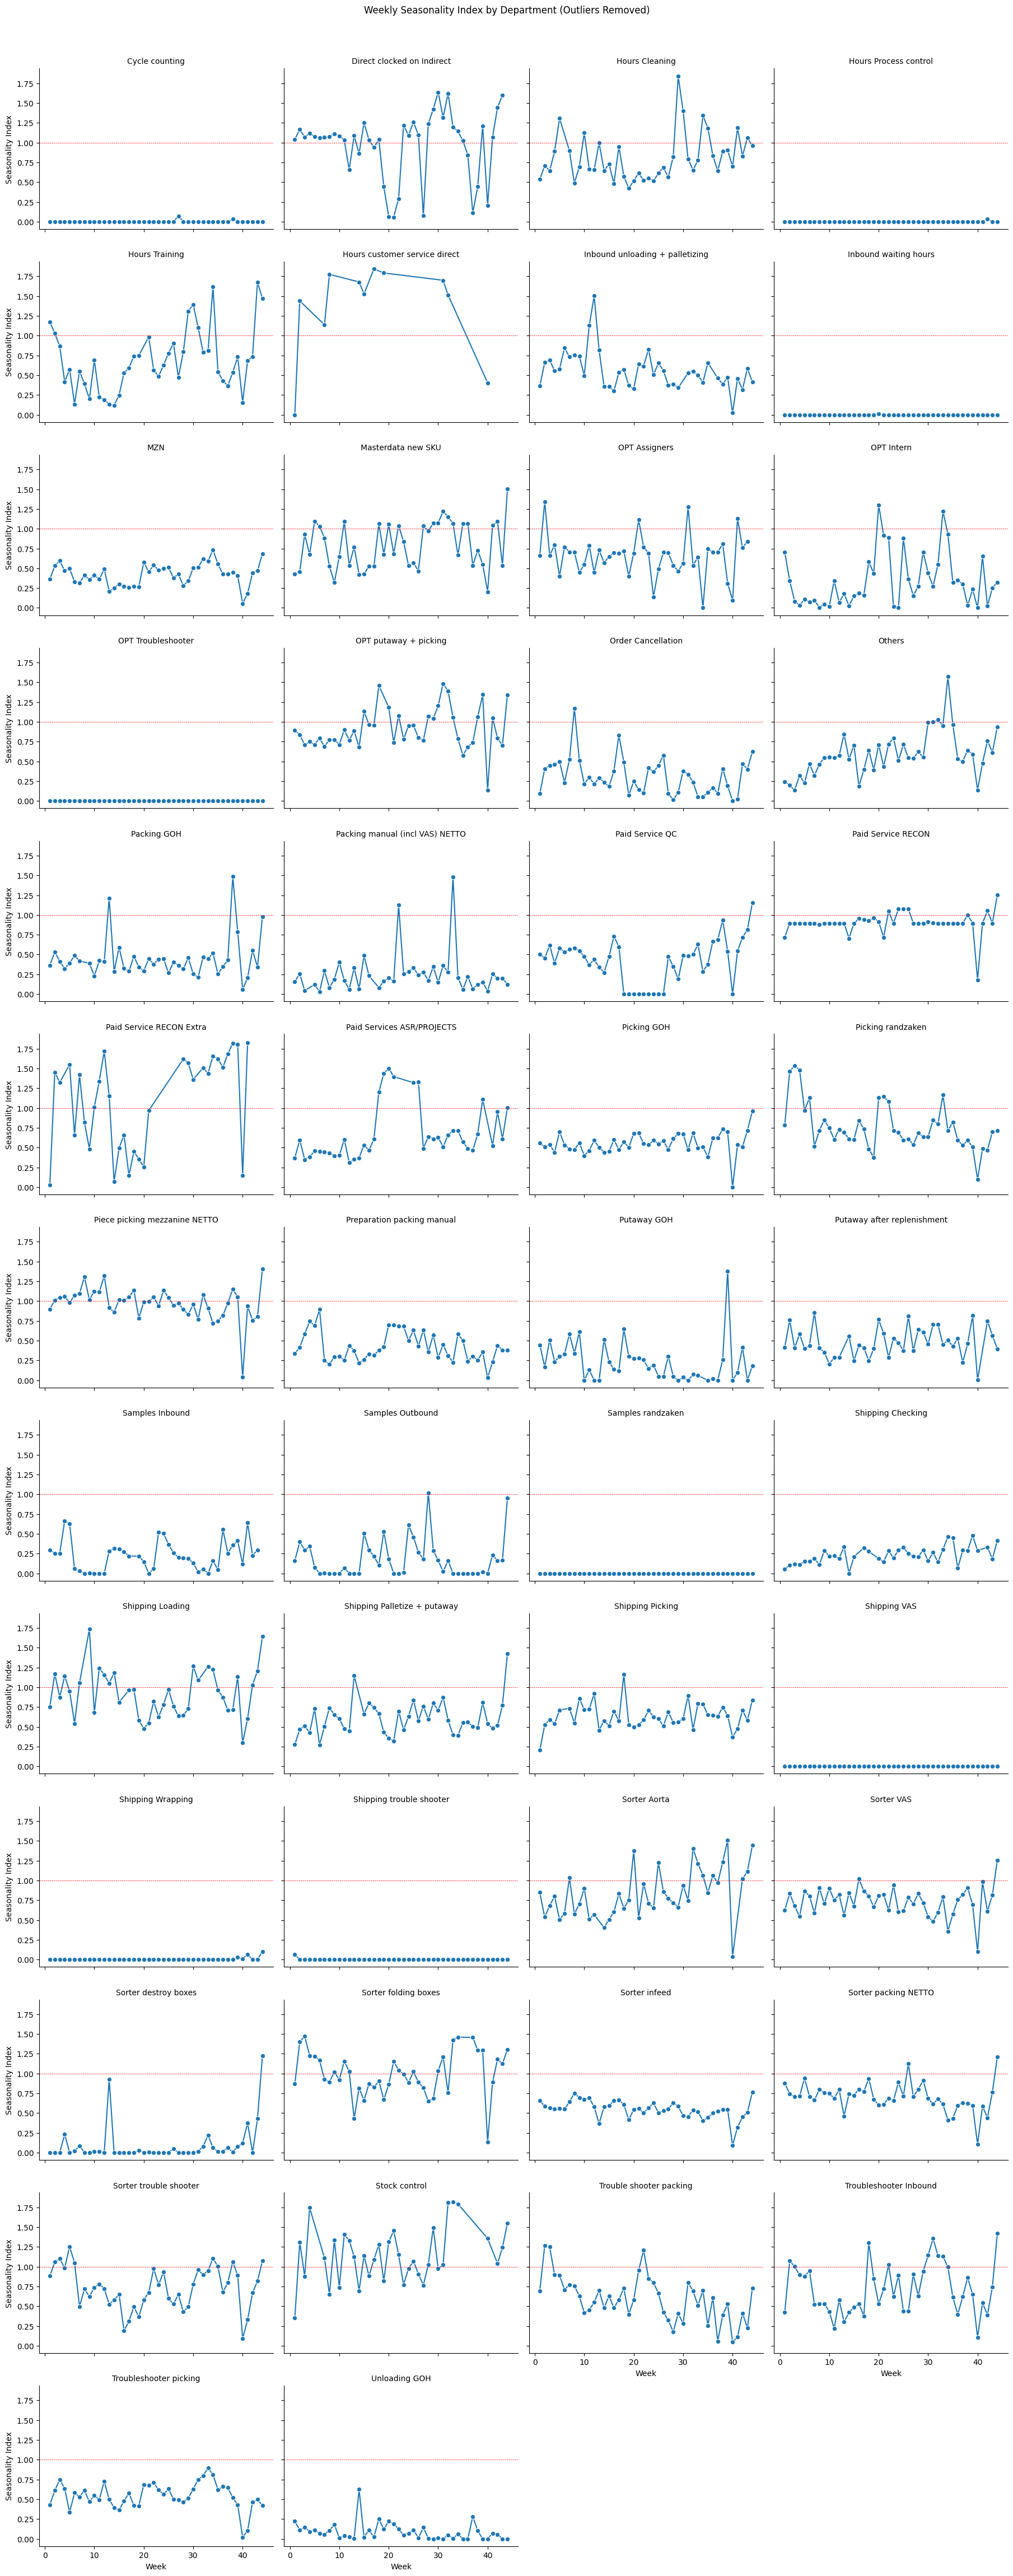

In [16]:
# Create small multiples for each department's seasonality index over the weeks
g = sns.FacetGrid(filtered_weekly_df, col='department', col_wrap=4, height=3.5, aspect=1.3, sharey=True)
g.map_dataframe(sns.lineplot, x='week', y='seasonality_index', marker='o')

# Add a horizontal line at seasonality index = 1
for ax in g.axes:
    ax.axhline(y=1, color='red', linestyle='--', linewidth=0.5)

# Set titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Week', 'Seasonality Index')
g.fig.suptitle('Weekly Seasonality Index by Department (Outliers Removed)', y=1.01)
plt.tight_layout()
plt.show()


In [ ]:
#jupyter nbconvert --to html seasonality.ipynb
